In [1]:
import jax
import jax.numpy as np

from numpy.polynomial.hermite import hermgauss

from structure_vb_lib import structure_model_lib, posterior_quantities_lib, data_utils, plotting_utils, preconditioner_lib, structure_cavi_lib
import structure_vb_lib.structure_optimization_lib as s_optim_lib

from bnpmodeling_runjingdev import result_loading_utils
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation
from bnpmodeling_runjingdev.bnp_optimization_lib import optimize_kl

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
seed = 98765
onp.random.seed(seed)

# Load data

In [3]:
g_obs, _, labels, _ = data_utils.load_thrush_data()

# subsample
# subs_indx = onp.random.choice(g_obs.shape[0], 30, replace = False)
# g_obs = g_obs[subs_indx]

loading thrush data from : 
../data/thrush_data/thrush-data.str


In [4]:
print(g_obs.shape)

(155, 7, 2, 21)


In [5]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]
n_allele = g_obs.shape[-1]

In [6]:
onp.unique(labels)

array(['Chawia', 'Mbololo', 'Ngangao', 'Yale'], dtype='<U32')

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params(n_allele)

alpha0 = 3.0
prior_params_dict['dp_prior_alpha'] = alpha0

prior_params_dict['ind_dp_prior_alpha'] = 6.0

prior_params_dict['allele_prior_lambda_vec'] *= 2.

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'dp_prior_alpha': 3.0, 'ind_dp_prior_alpha': 6.0, 'allele_prior_lambda_vec': DeviceArray([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
             2., 2., 2., 2., 2., 2.], dtype=float64)}


# Get VB params 

In [8]:
k_approx = 13

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs = n_obs,
                                                      n_loci = n_loci,
                                                      n_allele = n_allele, 
                                                      k_approx = k_approx, 
                                                      prng_key = jax.random.PRNGKey(23435))
    
print(vb_params_paragami)

OrderedDict:
	[global_params] = OrderedDict:
	[pop_freq_dirichlet_params] = NumericArrayPattern (13, 7, 21) (lb=0.0, ub=inf)
	[pop_stick_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (12,) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (12,) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (155, 12) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (155, 12) (lb=0.0, ub=inf)
	[pop_indx_multinom_params] = SimplexArrayPattern (155, 13) of 13-d simplices


In [11]:
structure_model_lib.get_kl(g_obs, 
                           vb_params_dict, 
                           prior_params_dict,
                           gh_loc, 
                           gh_weights)

DeviceArray(37148.90436118, dtype=float64)

In [12]:
vb_params_dict = structure_cavi_lib.run_cavi(g_obs, 
                             vb_params_dict, 
                             vb_params_paragami,
                             prior_params_dict,
                             gh_loc, gh_weights, 
                             max_iter = 40)

iteration [0]; kl:19450.592409; elapsed: 19.5031secs
iteration [1]; kl:18791.953294; elapsed: 2.7189secs
iteration [2]; kl:18641.096017; elapsed: 2.5717secs
iteration [3]; kl:18561.755693; elapsed: 2.1925secs
iteration [4]; kl:18497.899921; elapsed: 2.2765secs
iteration [5]; kl:18442.00024; elapsed: 2.2457secs
iteration [6]; kl:18391.220111; elapsed: 2.1522secs
iteration [7]; kl:18340.274034; elapsed: 2.0269secs
iteration [8]; kl:18287.174527; elapsed: 2.0317secs
iteration [9]; kl:18236.449233; elapsed: 2.0011secs
iteration [10]; kl:18196.720851; elapsed: 2.0793secs
iteration [11]; kl:18172.466671; elapsed: 1.918secs
iteration [12]; kl:18160.568655; elapsed: 1.6461secs
iteration [13]; kl:18155.51278; elapsed: 1.7123secs
iteration [14]; kl:18153.504019; elapsed: 1.7669secs
iteration [15]; kl:18152.583245; elapsed: 1.7165secs
iteration [16]; kl:18152.035675; elapsed: 1.5431secs
iteration [17]; kl:18151.675799; elapsed: 1.4599secs
iteration [18]; kl:18151.435321; elapsed: 1.4445secs
itera

In [13]:
vb_opt_dict, vb_opt, out, precon_obj, _ = \
    s_optim_lib.optimize_structure(g_obs,
                      vb_params_dict,
                      vb_params_paragami,
                      prior_params_dict, 
                      gh_loc, 
                      gh_weights, 
                      precondition_every = 10, 
                      max_lbfgs_iter = 2000)

compiling objective ... 
done. Elasped: 54.5616
compiling preconditioned objective ... 
not actually precoditioned
done. Elasped: 54.7605
init kl: 18150.949886
running L-BFGS
LBFGS-message:  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Elapsed: 0.174
running preconditioned newton-cg
iteration [3]; kl:18150.948311; elapsed: 14.326secs
    Optimization terminated successfully.
iteration [3]; kl:18150.948311; elapsed: 0.032secs
    Optimization terminated successfully.
x-tolerance reached
done. Elapsed 14.6918


In [ ]:
vb_op

In [22]:
def get_partial_kl(vb_global_params_free, ez_free, ec_free): 
    
    # fold parameters 
    vb_params_dict['global_params'] = vb_params_paragami['global_params'].fold(vb_global_params_free,
                                                              free = True)
    ez = jax.nn.softmax(ez_free, axis = -1)
    ec = jax.nn.softmax(ec_free, axis = -1)
    
    return structure_model_lib.get_kl(g_obs, 
                                       vb_params_dict, 
                                       prior_params_dict,
                                       gh_loc, 
                                       gh_weights, 
                                       e_z = ez, 
                                       e_c = ec)

In [23]:
vb_global_params_free = vb_params_paragami['global_params'].flatten(vb_params_dict['global_params'], 
                                                              free = True)

In [24]:
moments_dict = structure_model_lib.get_global_moments(vb_params_dict['global_params'],
                                                      gh_loc = gh_loc,
                                                      gh_weights = gh_weights)
                                            
    
# joint log likelihood
_, ez_free = \
    structure_model_lib.get_optimal_z(g_obs, 
                                      moments_dict['e_log_pop_freq'], 
                                      vb_params_dict['pop_indx_multinom_params'], 
                                      moments_dict['e_log_ind_cluster_probs'])

In [25]:
def get_optimal_ec(g_obs, ez, e_log_pop_freq, e_log_pop_cluster_probs): 
    
    g_times_popfreq = np.einsum('nlia, kla -> nlik', g_obs, e_log_pop_freq)
    
    ec_free = np.einsum('nlij, nlik -> njk', ez, g_times_popfreq) + \
                e_log_pop_cluster_probs
    
    return ec_free

In [26]:
ec_free = get_optimal_ec(g_obs, 
                         jax.nn.softmax(ez_free, axis = -1),
                         moments_dict['e_log_pop_freq'], 
                         moments_dict['e_log_pop_cluster_probs'])

In [27]:
get_partial_kl(vb_global_params_free, ez_free, ec_free)

DeviceArray(14552.68896926, dtype=float64)

In [29]:
optimize_kl(lambda x : get_partial_kl(x, ez_free, ec_free), 
            vb_params_dict['global_params'], 
            vb_params_paragami['global_params'])

compiling objective and derivatives ... 
done. Compile time: 29.134sec
Running L-BFGS-B ...
L-BFGS-B time: 0.231sec
BFGS out:  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Running trust-ncg ... 
14552.674431072981
14552.6741434854
14552.674133345223
14552.674133169172
Newton time: 0.728sec
Newton out:  Optimization terminated successfully.
done. 


(OrderedDict([('pop_freq_dirichlet_params',
               DeviceArray([[[  8.92178054,   4.10815452,   7.17661579, ...,
                                4.95954563,   2.05588321,   6.93276662],
                             [  4.06453285,  99.85606416,  25.47959617, ...,
                                1.99999985,   1.99999985,   1.99999985],
                             [ 13.84269208,   2.01876039,  30.73094694, ...,
                                2.00000006,   2.00000006,   2.00000006],
                             ...,
                             [  4.96306338,  69.50897002,  50.38817736, ...,
                                1.99999993,   1.99999993,   1.99999993],
                             [ 18.24065388,   2.399108  ,  72.57833776, ...,
                                1.9999998 ,   1.9999998 ,   1.9999998 ],
                             [ 40.39480702,  17.84588609,   2.02904898, ...,
                                1.99999968,   1.99999968,   1.99999968]],
               
     

In [81]:
grad_ec = jax.grad(get_partial_kl, 2)(vb_global_params_free, ez_free, ec_free)

In [82]:
np.abs(grad_ec).max()

DeviceArray(0.10441167, dtype=float64)

In [77]:
# set optimal z
moments_dict = structure_model_lib.get_global_moments(vb_params_dict['global_params'],
                                                      gh_loc = gh_loc,
                                                      gh_weights = gh_weights)
                                            
    
# joint log likelihood
_, ez_free = \
    structure_model_lib.get_optimal_z(g_obs, 
                                      moments_dict['e_log_pop_freq'], 
                                      jax.nn.softmax(ec_free, -1),  
                                      moments_dict['e_log_ind_cluster_probs'])

grad_ez = jax.grad(get_partial_kl, 1)(vb_global_params_free, ez_free, ec_free)

In [79]:
np.abs(grad_ez).max()

DeviceArray(2.0857982e-10, dtype=float64)

# Optimize

In [13]:
moments_dict = structure_model_lib.get_moments_from_vb_params_dict(vb_params_dict,
                                                                   gh_loc = gh_loc,
                                                                   gh_weights = gh_weights)
                                            
    
# joint log likelihood
ez, ez_free = \
    structure_model_lib.get_optimal_z(g_obs, 
                                      moments_dict['e_log_pop_freq'], 
                                      vb_params_dict['pop_indx_multinom_params'], 
                                      moments_dict['e_log_ind_cluster_probs'])

In [14]:
ez.shape

(155, 7, 2, 13)

In [16]:
moments_dict['e_log_pop_cluster_probs']

DeviceArray([ -0.45018773,  -1.69543602,  -2.87894492,  -3.65377716,
              -4.86040716,  -5.58024192,  -6.25883101,  -7.75035207,
              -8.53819964,  -9.6245549 , -10.78266459, -11.50342145,
             -11.66800486], dtype=float64)

In [18]:
vb_params_dict['pop_indx_multinom_params'].shape

(155, 13, 13)

In [19]:
ez.shape

(155, 7, 2, 13)

In [40]:
pop_freq_t = moments_dict['e_log_pop_freq'].transpose((1, 2, 0))
pop_freq_t = np.expand_dims(np.expand_dims(pop_freq_t, axis = 1), axis = 0)

In [42]:
(np.expand_dims(g_obs, axis = -1) * np.expand_dims(ez, axis = 3) * pop_freq_t)

(155, 7, 2, 21, 13)

In [43]:
g_obs.shape

(155, 7, 2, 21)

In [53]:
g_times_popfreq = np.einsum('nlia, kla -> nlik', g_obs, moments_dict['e_log_pop_freq'])
g_times_popfreq.shape

(155, 7, 2, 13)

In [57]:
update_pop_indx_multinom_free_params = np.einsum('nlij, nlik -> njk', ez, g_times_popfreq)

In [56]:
update_pop_indx_multinom_params.shape

(155, 13, 13)

In [ ]:
np.einsum('nlik')

In [11]:
vb_opt_dict, vb_opt, out, precon_obj, _ = \
    s_optim_lib.optimize_structure(g_obs,
                      vb_params_dict,
                      vb_params_paragami,
                      prior_params_dict, 
                      gh_loc, 
                      gh_weights, 
                      precondition_every = 50, 
                      max_lbfgs_iter = 2000)

compiling objective ... 
done. Elasped: 57.653
compiling preconditioned objective ... 
not actually precoditioned
done. Elasped: 53.7063
init kl: 9986.807820
running L-BFGS
LBFGS-message:  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Elapsed: 19.343
running preconditioned newton-cg
iteration [50]; kl:5400.260359; elapsed: 71.613secs
    Maximum number of iterations has been exceeded.
iteration [100]; kl:5400.233557; elapsed: 194.382secs
    Maximum number of iterations has been exceeded.
iteration [150]; kl:5400.225431; elapsed: 332.026secs
    Maximum number of iterations has been exceeded.
iteration [200]; kl:5399.248657; elapsed: 308.689secs
    Maximum number of iterations has been exceeded.
iteration [227]; kl:5399.238904; elapsed: 280.201secs
    Optimization terminated successfully.
iteration [227]; kl:5399.238904; elapsed: 0.014secs
    Optimization terminated successfully.
x-tolerance reached
done. Elapsed 1206.426


In [14]:
from bnpmodeling_runjingdev import cluster_quantities_lib

In [16]:
e_ind_cluster_probs = cluster_quantities_lib.get_e_cluster_probabilities(
                        vb_opt_dict['global_params']['ind_admix_params']['stick_means'], 
                        vb_opt_dict['global_params']['ind_admix_params']['stick_infos'],
                        gh_loc, gh_weights)

In [17]:
e_ind_admix = np.einsum('nk, nkj -> nj',
                        e_ind_cluster_probs,
                        vb_opt_dict['pop_indx_multinom_params'])


In [21]:
e_ind_admix[:, 0]

DeviceArray([0.99976134, 0.99982441, 0.99982174, 0.99978563, 0.99980616,
             0.99982507, 0.99984672, 0.99973777, 0.99980356, 0.99983041,
             0.99983725, 0.99974296, 0.99983556, 0.99984045, 0.99980762,
             0.99984134, 0.99985677, 0.99987039, 0.99986049, 0.9998767 ,
             0.99986046, 0.99981832, 0.99983363, 0.9998674 , 0.99978342,
             0.99986142, 0.99986379, 0.99986745, 0.99987571, 0.99979916,
             0.99982999, 0.99980351, 0.99986118, 0.9998595 , 0.99984685,
             0.99986641, 0.99988441, 0.99986088, 0.99985745, 0.99987095,
             0.99987422, 0.99986218, 0.99987184, 0.99984878, 0.99988524,
             0.99986223, 0.99983834, 0.99988383, 0.99985188, 0.99987485,
             0.99985918, 0.99988013, 0.9998422 , 0.99985775, 0.99985112,
             0.99981936, 0.99983986, 0.99988001, 0.99986328, 0.99985896,
             0.99988966, 0.99984833, 0.99987191, 0.99984923, 0.99979928,
             0.99987213, 0.99984381, 0.99988713, 0.

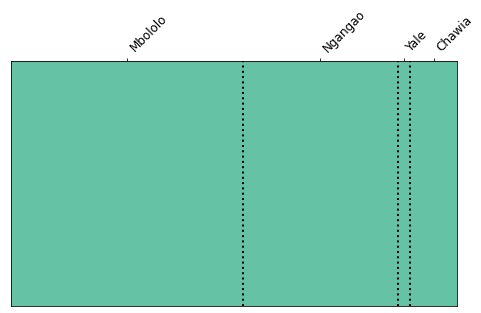

In [18]:
# e_ind_admix = posterior_quantities_lib.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]

# sort everything within populations
perm_obs = data_utils.cluster_admix_get_indx_within_labels(onp.array(e_ind_admix),
                                                               labels)

# now re-order populations: put chawia last
_labels = deepcopy(labels)
_labels[_labels == 'Chawia'] = 'z'
perm2 = onp.argsort(_labels)
perm_obs = perm_obs[perm2]

# plot admixture
fig, ax = plt.subplots(1, 1, figsize = (8, 4.5))

plotting_utils.plot_top_clusters(onp.array(e_ind_admix)[perm_obs], 
                                 ax,
                                 3, 
                                 cmap_colors = plt.get_cmap('Set2').colors);

# print labels
plotting_utils.draw_region_separation(labels[perm2], ax);

In [32]:
out.message

'Optimization terminated successfully.'

In [14]:
hess = jax.hessian(stru_precon_obj.f)(vb_opt)

In [15]:
x_c = stru_precon_obj.precondition(vb_opt, vb_opt)
hess_precond = jax.hessian(lambda x_c : stru_precon_obj.f_precond(x_c, vb_opt))(x_c)

In [16]:
np.abs(hess - hess.transpose()).max()

DeviceArray(4.4408921e-15, dtype=float64)

In [17]:
np.abs(hess_precond - hess_precond.transpose()).max()

DeviceArray(nan, dtype=float64)

In [20]:
A = jax.lax.map(lambda x_c : stru_precon_obj._unprecondition(x_c, vb_opt), 
                np.eye(len(vb_opt)))

In [21]:
np.abs(A - A.transpose()).max()

DeviceArray(1.13686838e-13, dtype=float64)

In [83]:
A - A.transpose()

DeviceArray([[ 0.00000000e+00,  3.46944695e-18, -3.46944695e-18, ...,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
             [-3.46944695e-18,  0.00000000e+00, -6.93889390e-18, ...,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
             [ 3.46944695e-18,  6.93889390e-18,  0.00000000e+00, ...,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
             ...,
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],            dtype=float64)

In [88]:
A2 = jax.lax.map(lambda v : preconditioner_lib.get_mfvb_cov_matmul(v,
                                                               vb_opt_dict,
                                                               vb_params_paragami, 
                                                               return_info = False, 
                                                               return_sqrt = False), 
                 np.eye(len(vb_opt)))

In [89]:
np.abs(A2 - A2.transpose()).max()

DeviceArray(6.77626358e-21, dtype=float64)

In [97]:
vb_opt_dict['pop_indx_multinom_params'].shape

(30, 5, 5)

In [98]:
k_approx

5

In [108]:
foo = jax.lax.map(lambda v : preconditioner_lib._get_multinomial_covariance(vb_opt_dict['pop_indx_multinom_params'][0, 0], 
                                               return_info = False, 
                                               return_sqrt = False, 
                                               v = v), 
                  np.eye(k_approx - 1))

In [109]:
np.abs(foo - foo.transpose()).max()

DeviceArray(7.52316385e-37, dtype=float64)

In [113]:
blah = np.linalg.inv(0.5 * (foo + foo.transpose()))

In [23]:
def evaluate_condition_number(kl_hess): 
    # get eigenvalues
    kl_hess_evals = np.linalg.eigvals(kl_hess)

    # all real
    assert np.all(np.imag(kl_hess_evals) == 0.)
    kl_hess_evals = np.real(kl_hess_evals)

    # all positive 
    assert np.all(kl_hess_evals) > 0

    print((kl_hess_evals.max(), 
           kl_hess_evals.min()))

    cn_hess = kl_hess_evals.max() / \
                kl_hess_evals.min()

    return cn_hess


In [24]:
x_c = stru_precon_obj.precondition(vb_opt, vb_opt)
kl_hess_precond = jax.lax.map(lambda v : \
                              stru_precon_obj.hvp_precond(x_c, vb_opt, v), 
                              np.eye(len(vb_opt)))

In [27]:
np.abs(kl_hess_precond - kl_hess_precond.transpose()).max()

DeviceArray(6.57109922e-11, dtype=float64)

In [28]:
evaluate_condition_number(kl_hess_precond)

(DeviceArray(5095.95744686, dtype=float64), DeviceArray(1.56393858e-06, dtype=float64))


DeviceArray(3.25841278e+09, dtype=float64)

In [29]:
evaluate_condition_number(hess)

(DeviceArray(26.73888649, dtype=float64), DeviceArray(1.5631521e-12, dtype=float64))


DeviceArray(1.71057484e+13, dtype=float64)

In [67]:
evaluate_condition_number(precond)

(DeviceArray(4121.14458872, dtype=float64), DeviceArray(0.3073217, dtype=float64))


DeviceArray(13409.87190198, dtype=float64)

In [ ]:
hess_precond = jax.hessian(lambda x_c : stru_precon_obj.f_precond(x_c, vb_opt))(vb_opt)

In [64]:
precond = jax.lax.map(lambda v : preconditioner_lib.get_mfvb_cov_matmul(v,
                                                               vb_params_dict,
                                                               vb_params_paragami, 
                                                               return_info = True, 
                                                               return_sqrt = False), 
             np.eye(len(vb_opt)))

In [66]:
np.linalg.eigvals(precond).min()

DeviceArray(0.3073217+0.j, dtype=complex128)

In [44]:
np.abs(precond - precond.transpose()).max()

DeviceArray(6.82121026e-13, dtype=float64)

In [19]:
x_c = stru_precon_obj.precondition(vb_opt, vb_opt)
kl_hess_precond = jax.lax.map(lambda v : \
                              stru_precon_obj.hvp_precond(x_c, vb_opt, v), 
                              np.eye(len(vb_opt)))

In [48]:
np.abs(kl_hess_precond - kl_hess_precond.transpose()).max()

DeviceArray(6.44840243e+10, dtype=float64)

In [20]:
def evaluate_condition_number(kl_hess): 
    # get eigenvalues
    kl_hess_evals = np.linalg.eigvals(kl_hess)

    # all real
    assert np.all(np.imag(kl_hess_evals) == 0.)
    kl_hess_evals = np.real(kl_hess_evals)

    # all positive 
    assert np.all(kl_hess_evals) > 0

    print((kl_hess_evals.max(), 
           kl_hess_evals.min()))

    cn_hess = kl_hess_evals.max() / \
                kl_hess_evals.min()

    return cn_hess


In [21]:
evaluate_condition_number(kl_hess)

(DeviceArray(26.73888649, dtype=float64), DeviceArray(1.56400846e-12, dtype=float64))


DeviceArray(1.70963823e+13, dtype=float64)

In [38]:
np.abs(kl_hess_precond - kl_hess_precond.transpose()).max()

DeviceArray(6.44840243e+10, dtype=float64)

In [39]:
np.abs(kl_hess - kl_hess.transpose()).max()

DeviceArray(4.4408921e-15, dtype=float64)

In [22]:
evaluate_condition_number(kl_hess_precond)

AssertionError: 

In [16]:
def get_kl_loss(vb_params_free): 
        
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)

    return structure_model_lib.get_kl(g_obs,
                  vb_params_dict,
                  prior_params_dict,
                  gh_loc,
                  gh_weights, 
                  e_log_phi = None).squeeze()

In [17]:
hessian = jax.hessian(get_kl_loss)(vb_opt)

In [18]:
get_precond = lambda v : preconditioner_lib.get_mfvb_cov_matmul(v,
                                                                vb_opt_dict,
                                                                vb_params_paragami)

In [16]:
v = vb_params_paragami.flatten(vb_params_dict, free = True)

In [13]:
preconditioner_lib.get_mfvb_cov_matmul(v,
                                       vb_params_dict,
                                       vb_params_paragami)

DeviceArray([-0.38586031,  1.49372912,  0.93102162, ...,  0.39495206,
              0.18304372,  0.15314764], dtype=float64)

In [11]:
vb_params_paragami.flat_length(free = True)

DeviceArray(29835, dtype=int64)

In [12]:
vb_params_dict['pop_freq_dirichlet_params'] = np.ones((k_approx, n_loci, n_allele))

In [13]:
v = vb_params_paragami['pop_freq_dirichlet_params'].flatten(vb_params_dict['pop_freq_dirichlet_params'], free = False)

In [14]:
v

DeviceArray([1., 1., 1., ..., 1., 1., 1.], dtype=float64)

In [15]:
preconditioner_lib._eval_dirichlet_cov_matmul(vb_params_dict['pop_freq_dirichlet_params'],
                                            return_info = True,
                                            return_sqrt = True, 
                                            v = v)

DeviceArray([1.26923711, 1.26923711, 1.26923711, ..., 1.26923711,
             1.26923711, 1.26923711], dtype=float64)

In [16]:
v = vb_params_paragami['pop_stick_params'].flatten(vb_params_dict['pop_stick_params'], free = True)
preconditioner_lib._eval_normal_cov_matmul(vb_params_dict['pop_stick_params']['stick_infos'],
                                           return_info = True, 
                                           return_sqrt = True, 
                                           v = v)

DeviceArray([0.50014647, 0.31590509, 0.17728086, 0.46335696, 0.03770306,
             0.26829247, 0.59332169, 0.21171173, 0.32319164, 0.28941576,
             0.05005665, 0.10418899, 1.01089659, 1.18816293, 0.18220489,
             0.07856012, 0.89402049, 0.09936517, 1.05317718, 0.77259757,
             1.34996887, 0.98910597, 0.46208027, 1.29318817],            dtype=float64)

In [17]:
v = vb_params_paragami['ind_admix_params'].flatten(vb_params_dict['ind_admix_params'], free = True)
preconditioner_lib._eval_normal_cov_matmul(vb_params_dict['ind_admix_params']['stick_infos'],
                                           return_info = True, 
                                           return_sqrt = True, 
                                           v = v).shape

(3720,)

In [19]:
v = vb_params_paragami['pop_indx_multinom_params'].flatten(vb_params_dict['pop_indx_multinom_params'], free = True)

preconditioner_lib._eval_multinomial_cov_matmul(vb_params_dict['pop_indx_multinom_params'],
                             return_info = True,
                             return_sqrt = True, 
                             v = v).shape

(24180,)

In [20]:
v.shape

(24180,)

In [22]:
vb_params_paragami['pop_indx_multinom_params'].flatten(vb_params_dict['pop_indx_multinom_params'], free = False).shape

(26195,)

In [28]:
vb_params_dict['pop_indx_multinom_params'].shape

(155, 13, 13)

In [30]:
vb_params_paragami['pop_indx_multinom_params'].freeing_jacobian?

Object `freeing_jacobian` not found.


In [35]:
vb_params_paragami['pop_indx_multinom_params'].freeing_jacobian(vb_params_dict['pop_indx_multinom_params'])

<24180x26195 sparse matrix of type '<class 'numpy.float64'>'
	with 314340 stored elements in COOrdinate format>

In [46]:
paragami.simplex_patterns._constrain_simplex_jacobian(vb_params_dict['pop_indx_multinom_params'][0, 0]).shape

(13, 12)

In [15]:
_get_log_dirichlet_covariance(dirichlet_params,
                              vb_params_dict['pop_freq_dirichlet_params'][0], 
                              return_info = True,
                              return_sqrt = True)

SyntaxError: invalid syntax (<ipython-input-15-5e72667fd8e1>, line 2)

In [11]:
structure_model_lib.get_kl(g_obs, 
                           vb_params_dict, 
                           prior_params_dict, 
                           gh_loc, 
                           gh_weights)

DeviceArray(20825.30457599, dtype=float64)

In [12]:
np.stack((np.eye(k_approx), ) * 2).shape

(2, 13, 13)

### Init 

# Timing results

In [13]:
def get_kl_loss(vb_params_free): 
        
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)

    return structure_model_lib.get_kl(g_obs,
                  vb_params_dict,
                  prior_params_dict,
                  gh_loc,
                  gh_weights, 
                  e_log_phi = None).squeeze()

In [14]:
from bnpmodeling_runjingdev.sensitivity_lib import get_jac_hvp_fun

In [15]:
get_loss = jax.jit(get_kl_loss)
get_grad = jax.jit(jax.grad(get_kl_loss))
get_hvp = jax.jit(get_jac_hvp_fun(get_kl_loss))

In [16]:
x = vb_params_paragami.flatten(vb_params_dict, free = True)

In [17]:
# compile 
t0 = time.time()
_ = get_loss(x)
_ = get_grad(x)
_ = get_hvp(x, x).block_until_ready()

print(time.time() - t0)

57.7808575630188


In [18]:
t0 = time.time() 
_ = get_loss(x).block_until_ready()
print(time.time() - t0)

0.008693218231201172


In [19]:
t0 = time.time() 
_ = get_grad(x).block_until_ready()
print(time.time() - t0)

0.020191431045532227


In [20]:
t0 = time.time() 
_ = get_hvp(x, x).block_until_ready()
print(time.time() - t0)

0.038620948791503906


# Optimize

In [21]:
optimize_kl(get_loss,
            vb_params_dict, 
            vb_params_paragami,
            get_grad = get_grad,
            get_hvp = get_hvp,
            lbfgs_maxiter = 2000, 
            run_lbfgs = True,
            run_newton = True)

compiling objective and derivatives ... 
done. Compile time: 3.300sec
Running L-BFGS-B ...
L-BFGS-B time: 78.650sec
BFGS out:  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Running trust-ncg ... 
7824.739918467043
7824.739826472816
7824.736946554231
7824.735882588138
7824.731481944415
7824.711830368705
7824.946709140377
7824.632398561504
7824.788377702702
7824.5042923606725
7824.2016543651025
7823.083595930404
7822.718917439303
7822.6507404020695
7822.600221216028
7822.578286330088
7822.550353530971
7822.53907452549
7822.52223720009
7822.514169206554
7822.5038042792985
7822.501092518361
7822.489677734062
7822.484930595665
7827.055996224964


KeyboardInterrupt: 

In [ ]:
# vb_opt_dict, vb_opt, ez_opt, out, _ = \
#     optimize_structure(g_obs,
#                       vb_params_dict,
#                       vb_params_paragami,
#                       prior_params_dict, 
#                       gh_loc, 
#                       gh_weights, 
#                       lbfgs_maxiter = 500)

In [14]:
out.fun

array(7824.73991847)

In [15]:
out.hess_inv(out.x)

array([ 1.86975836, -1.29663261, -0.99047517, ..., -4.37717932,
       -3.92164866, -4.141545  ])

In [24]:
out

      fun: array(7824.73991847)
 hess_inv: <29835x29835 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.60019249e-06, -9.01481027e-06, -7.04385847e-06, ...,
       -5.15905242e-06, -4.44266416e-06, -4.79865985e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1462
      nit: 1343
     njev: 1462
   status: 0
  success: True
        x: array([ 4.14621224e-04,  8.47741770e-04,  9.85358316e-04, ...,
       -1.11488375e+00, -1.11492263e+00, -1.11493873e+00])

In [16]:
# vb_dict_tmp = paragami.load_folded('../fits/thrush_fits/thrush_fit_alpha3.0.npz')[0]
# np.abs(vb_params_paragami.flatten(vb_dict_tmp, free = True) -vb_opt).max()

In [17]:
ez_opt.sum(0).sum(0).sum(0)

DeviceArray([2.06104120e+03, 8.24934924e+01, 1.71084551e+01,
             5.94535751e+00, 2.15451382e+00, 7.91801604e-01,
             2.92467593e-01, 1.08224217e-01, 4.00750165e-02,
             1.48432265e-02, 5.49832941e-03, 2.03673663e-03,
             2.03690941e-03], dtype=float64)

# Check out the fit

In [18]:
from bnpmodeling_runjingdev import cluster_quantities_lib

In [19]:
e_ind_cluster_probs = cluster_quantities_lib.get_e_cluster_probabilities(
                        vb_opt_dict['ind_admix_params']['stick_means'], 
                        vb_opt_dict['ind_admix_params']['stick_infos'],
                        gh_loc, gh_weights)

In [47]:
e_ind_cluster_probs[4]

DeviceArray([6.99943142e-01, 2.29572994e-01, 3.69414540e-02,
             1.70423408e-02, 8.29766527e-03, 4.10966401e-03,
             2.04789720e-03, 1.02265726e-03, 5.11128463e-04,
             2.55535539e-04, 1.27756772e-04, 6.38792268e-05,
             6.38854635e-05], dtype=float64)

In [20]:
e_ind_admix = np.einsum('nk, nkj -> nj',
                        e_ind_cluster_probs,
                        vb_opt_dict['pop_indx_multinom_params'])

# e_ind_admix = e_ind_cluster_probs

In [25]:
foo = cluster_quantities_lib.get_e_cluster_probabilities(
                        vb_opt_dict['pop_stick_params']['stick_means'], 
                        vb_opt_dict['pop_stick_params']['stick_infos'],
                        gh_loc, gh_weights)

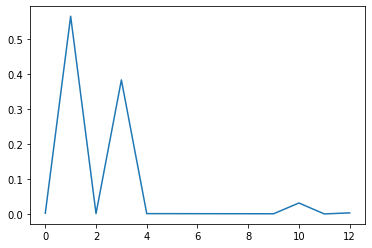

In [27]:
plt.plot(foo)

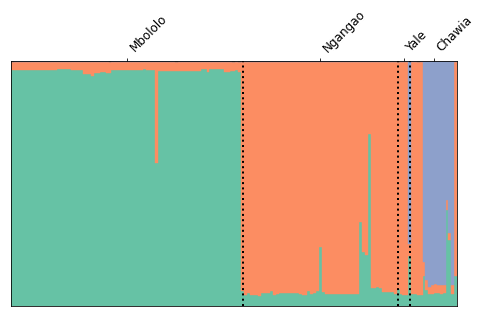

In [22]:
# e_ind_admix = posterior_quantities_lib.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]

# sort everything within populations
perm_obs = data_utils.cluster_admix_get_indx_within_labels(onp.array(e_ind_admix),
                                                               labels)

# now re-order populations: put chawia last
_labels = deepcopy(labels)
_labels[_labels == 'Chawia'] = 'z'
perm2 = onp.argsort(_labels)
perm_obs = perm_obs[perm2]

# plot admixture
fig, ax = plt.subplots(1, 1, figsize = (8, 4.5))

plotting_utils.plot_top_clusters(onp.array(e_ind_admix)[perm_obs], 
                                 ax,
                                 3, 
                                 cmap_colors = plt.get_cmap('Set2').colors);

# print labels
plotting_utils.draw_region_separation(labels[perm2], ax);

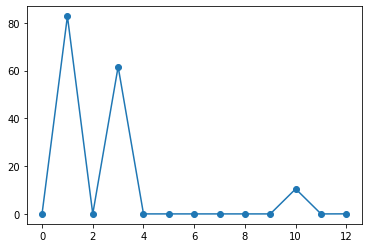

In [23]:
plt.plot(e_ind_admix.sum(0), marker = 'o')

In [65]:
np.argwhere(e_ind_admix.max(1) < 0.6)

DeviceArray([[ 6],
             [78]], dtype=int64)

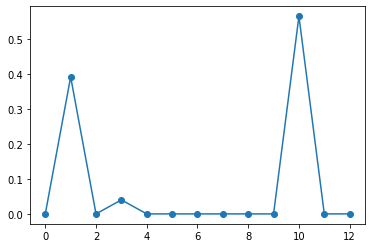

In [67]:
plt.plot(e_ind_admix[6], marker = 'o')

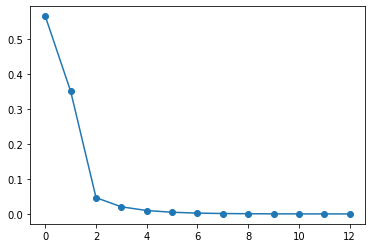

In [74]:
plt.plot(e_ind_cluster_probs[6], marker = 'o')

In [76]:
vb_opt_dict['pop_indx_multinom_params'][6][0]

DeviceArray([9.13482255e-09, 1.65818796e-07, 2.91182383e-09,
             4.85459415e-08, 3.27399046e-09, 2.41756933e-09,
             1.93314787e-09, 5.80692871e-09, 4.94446790e-09,
             5.26240512e-09, 9.99999744e-01, 2.54400203e-09,
             3.65492700e-09], dtype=float64)

In [28]:
allele = 3
foo = vb_opt_dict['pop_freq_dirichlet_params'][-1, allele] 
foo / foo.sum()

DeviceArray([0.04864292, 0.04788846, 0.0477057 , 0.0475424 , 0.04754238,
             0.04754236, 0.0475424 , 0.04754238, 0.04754241, 0.04754239,
             0.04754237, 0.04754238, 0.04754239, 0.04754236, 0.04754237,
             0.04754237, 0.04754238, 0.04754241, 0.04754241, 0.04754238,
             0.04754239], dtype=float64)

In [102]:
x, y = np.unique(g_obs[:, allele, :, :].argmax(-1).flatten(), 
         return_counts = True)

In [103]:
x

DeviceArray([0, 1, 2, 3, 4, 5], dtype=int64)

In [104]:
y / y.sum()

DeviceArray([0.10322581, 0.00322581, 0.1516129 , 0.16451613, 0.09032258,
             0.48709677], dtype=float64)

In [110]:
from bnpgmm_runjingdev import gmm_optimization_lib

In [113]:
init_centroids, km_best = \
    gmm_optimization_lib.init_centroids_w_kmeans(g_obs.reshape(n_obs, -1), 
                                             k_approx)

In [114]:
km_best.labels_

array([12, 12,  2, 10,  1, 10, 12,  1,  1, 10, 12, 10, 15, 10, 15,  1,  1,
        0,  4, 18,  9, 11,  3, 17, 12, 11, 11,  6, 17,  6, 17,  0,  0,  0,
       11, 17,  4,  0,  6,  4, 17,  4,  3,  4,  3,  3, 11, 18,  3,  3,  0,
        0, 16,  4, 16, 16, 18, 18, 17, 11, 18,  1, 17,  3,  3,  4,  0, 17,
       17,  6,  0,  3,  6,  6, 16, 17,  0,  0,  9,  6, 18, 11,  3, 16,  3,
        6,  6, 17, 17, 18,  3,  4, 17, 17,  4,  0,  4, 14,  8,  8, 14, 15,
       19,  7,  8, 14,  8,  2, 19, 15,  7, 14,  2,  9, 14,  9,  2,  5,  2,
       14, 15,  5, 14, 19, 15, 14,  5, 11, 15, 14,  7, 13,  5,  5,  5,  5,
        7,  7,  5,  5,  2,  9,  8, 15, 13, 15,  7,  5,  5,  7,  5,  8, 14,
       15,  2], dtype=int32)

In [ ]:
coclust = np.dot(e_ind_admix[perm_obs], 
                 e_ind_admix[perm_obs].transpose())

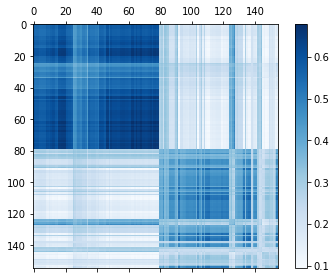

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4.5))

im0 = ax.matshow(coclust, 
                 cmap = plt.get_cmap('Blues'))

fig.colorbar(im0, ax = ax)

In [16]:
e_num_loci_per_cluster = posterior_quantities_lib.get_e_num_loci_per_cluster(g_obs, vb_opt_dict, gh_loc, gh_weights)
e_num_ind_per_cluster = posterior_quantities_lib.get_e_num_ind_per_cluster(vb_opt_dict, gh_loc, gh_weights)

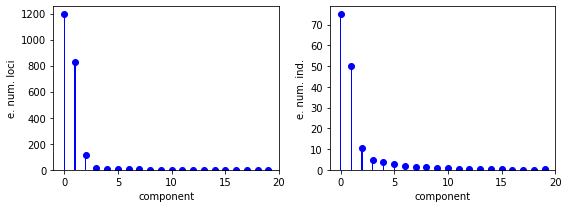

In [17]:
fig, axarr = plt.subplots(1, 2, figsize = (8, 3))

result_loading_utils._plot_weights(e_num_loci_per_cluster, 
                                   axarr[0])

result_loading_utils._plot_weights(e_num_ind_per_cluster, 
                                   axarr[1])


axarr[0].set_ylabel('e. num. loci')
axarr[1].set_ylabel('e. num. ind.')
    
fig.tight_layout()

# Define sensitivity object

In [20]:
# initial prior alpha
use_free_alpha = True
hyper_param0 = prior_params_paragami['dp_prior_alpha'].flatten(alpha0, 
                                                              free = use_free_alpha)

In [21]:
# set up objective as function of vb params and prior param 

def objective_fun(vb_params_dict, alpha): 
    
    _prior_params_dict = deepcopy(prior_params_dict)
    _prior_params_dict['dp_prior_alpha'] = alpha
    
    return structure_model_lib.get_kl(g_obs, 
                          vb_params_dict,
                          _prior_params_dict,
                          gh_loc, 
                          gh_weights).squeeze()


objective_fun_free = paragami.FlattenFunctionInput(
                                original_fun=objective_fun, 
                                patterns = [vb_params_paragami, prior_params_paragami['dp_prior_alpha']],
                                free = [True, use_free_alpha],
                                argnums = [0, 1])

### The sensitivity object

# Fit for a range of alpha

In [22]:
alpha_list = np.arange(1, 15, dtype = float)

### Define loss as function of free params and alpha
and we precompile its derivatives beforehand

In [23]:
get_fun = jax.jit(objective_fun_free)

get_grad = jax.jit(jax.grad(objective_fun_free, argnums = 0))

def _get_hvp(x, hyper_param0, v):
    return jax.jvp(jax.grad(objective_fun_free, argnums = 0), (x, hyper_param0), (v, 0.))[1]

get_hvp = jax.jit(_get_hvp)

In [24]:
# compile ... 
_ = get_fun(vb_opt, hyper_param0).block_until_ready()
_ = get_grad(vb_opt, hyper_param0).block_until_ready()
_ = get_hvp(vb_opt, hyper_param0, vb_opt).block_until_ready()

In [25]:
def refit_with_alpha(alpha, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    hyper_param0 = prior_params_paragami['dp_prior_alpha'].flatten(alpha, free = use_free_alpha)
    
    vb_opt_pert = optimize_kl(lambda x : get_fun(x, hyper_param0),
                             new_init_dict, 
                             vb_params_paragami, 
                             get_grad = lambda x : get_grad(x, hyper_param0),
                             get_hvp = lambda x, v: get_hvp(x, hyper_param0, v),
                             run_lbfgs = False,
                             run_newton = True)[1]                             
        
    return vb_opt_pert

In [26]:
refit_list = []

new_init_dict = deepcopy(vb_opt_dict)

for alpha in alpha_list: 
    print('\n################')
    print('re-optimzing with alpha = ', alpha)
    print('################')
    
    refit_list.append(refit_with_alpha(alpha, new_init_dict))


################
re-optimzing with alpha =  1.0
################
compiling objective and derivatives ... 
done. Compile time: 2.900sec
Running trust-ncg ... 
Newton time: 10.406sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with alpha =  2.0
################
compiling objective and derivatives ... 
done. Compile time: 2.827sec
Running trust-ncg ... 
Newton time: 5.948sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with alpha =  3.0
################
compiling objective and derivatives ... 
done. Compile time: 2.841sec
Running trust-ncg ... 
Newton time: 0.033sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with alpha =  4.0
################
compiling objective and derivatives ... 
done. Compile time: 2.843sec
Running trust-ncg ... 
Newton time: 6.437sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with alpha =

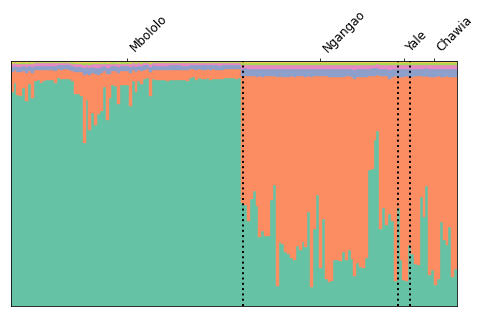

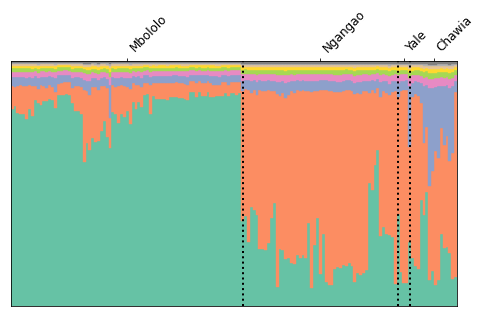

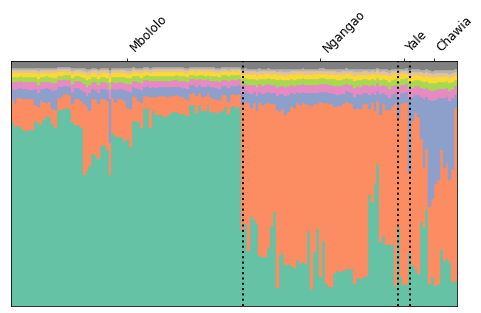

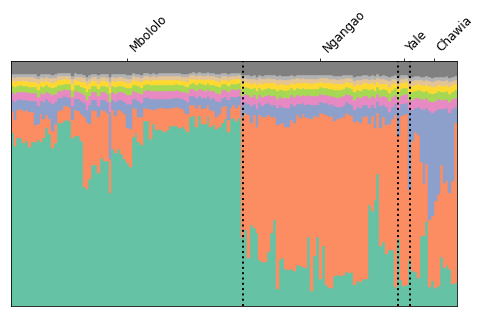

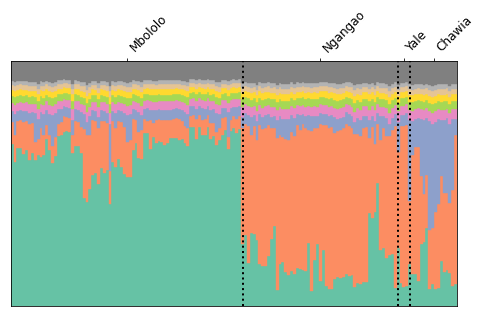

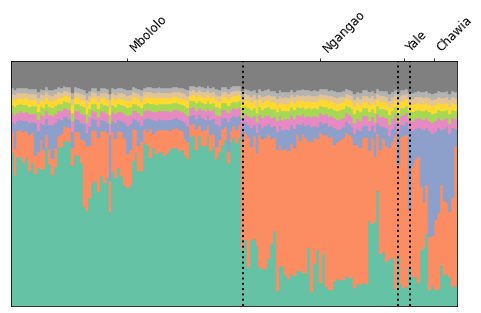

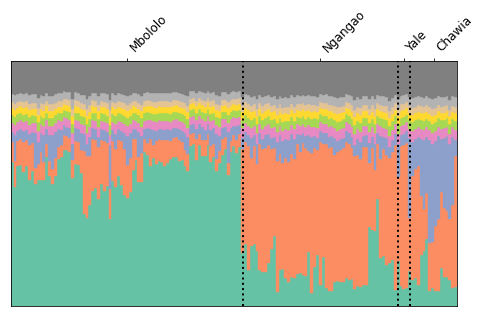

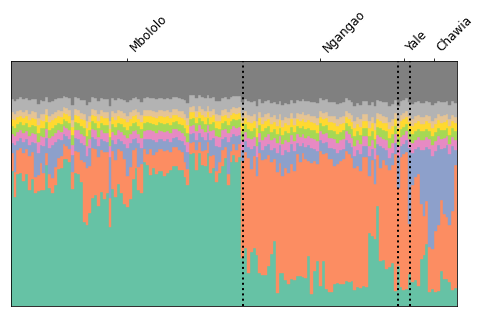

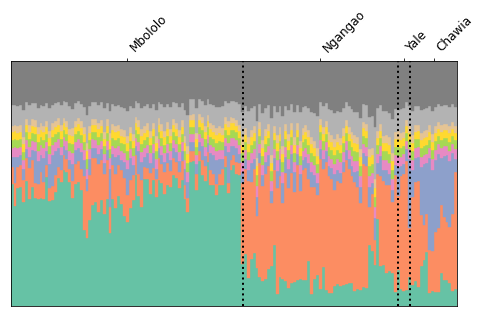

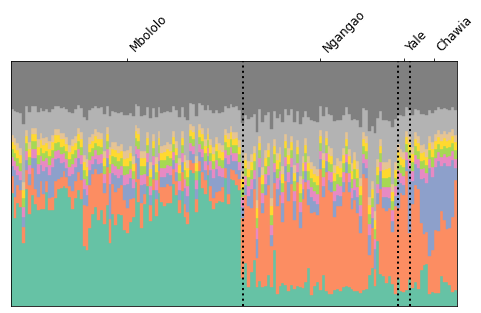

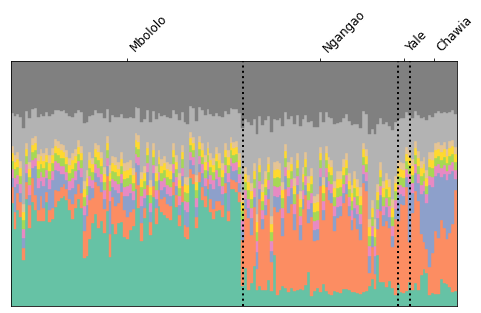

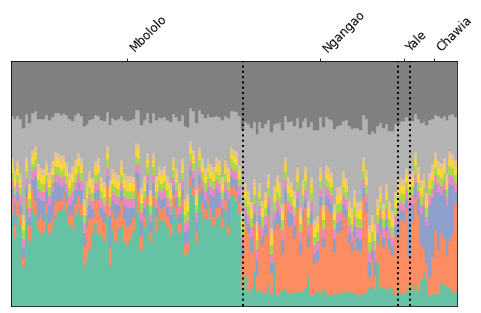

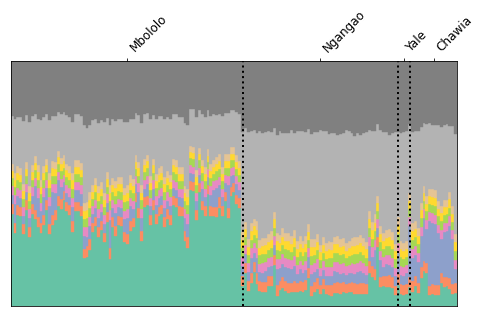

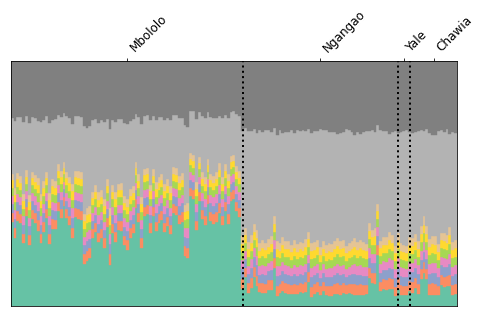

In [28]:
for i in range(len(alpha_list)):
    
    vb_params_dict = vb_params_paragami.fold(refit_list[i], free = True)
    
    e_ind_admix = posterior_quantities_lib.get_vb_expectations(vb_params_dict, 
                                                               gh_loc,
                                                               gh_weights)[0][perm_obs]
    
    
    fig, ax = plt.subplots(1, 1, figsize = (8, 4.5))

    plotting_utils.plot_top_clusters(onp.array(e_ind_admix), 
                                 ax,
                                 8, 
                                 cmap_colors = plt.get_cmap('Set2').colors);

    # print labels
    plotting_utils.draw_region_separation(labels[perm2], ax);

# Number of clusters

In [28]:
prng_key = jax.random.PRNGKey(223)

@jax.jit
def get_n_clusters_insample(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.get_e_num_clusters(g_obs,
                                                       vb_params_dict,
                                                       gh_loc,
                                                       gh_weights,
                                                       threshold = 0,
                                                       n_samples = 10000, 
                                                       prng_key = prng_key)

@jax.jit
def get_n_clusters_pred(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.get_e_num_pred_clusters(vb_params_dict,
                                                            gh_loc, 
                                                            gh_weights, 
                                                            threshold = 0,
                                                            prng_key = prng_key)

In [29]:
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 16
title_fontsize = 20

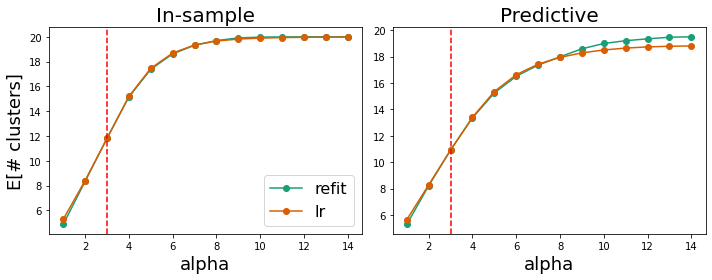

In [30]:
fig, axarr = plt.subplots(1, 2, figsize = (10, 4))

# in sample number of clusters
result_loading_utils.plot_post_stat_per_epsilon(get_n_clusters_insample, 
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               axarr[0])
axarr[0].legend()
axarr[0].set_title('In-sample', fontsize = title_fontsize)
axarr[0].set_ylabel('E[# clusters]')

# predictive number of clusters
result_loading_utils.plot_post_stat_per_epsilon(get_n_clusters_pred, 
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               axarr[1])

axarr[1].set_title('Predictive', fontsize = title_fontsize)

for i in range(2):
    axarr[i].axvline(alpha0, 
                     color = 'red', 
                     linestyle = '--')
    axarr[i].set_xlabel('alpha')
    


fig.tight_layout()
# fig.savefig('../../writing/notes_for_tamara/figures/structure_alpha_e_num_clusters.png')

### Thresholded

In [31]:
prng_key = jax.random.PRNGKey(223)

threshold1 = np.ceil((n_obs * n_loci * 2) * 0.01)
threshold2 = np.ceil(n_obs * 0.01)

print(threshold1)
print(threshold2)

@jax.jit
def get_n_clusters_insample_thresh(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.get_e_num_clusters(g_obs,
                                                            vb_params_dict,
                                                            gh_loc, gh_weights,
                                                            threshold = threshold1,
                                                            n_samples = 1000, 
                                                            prng_key = prng_key)

@jax.jit
def get_n_clusters_pred_thresh(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.get_e_num_pred_clusters(vb_params_dict,
                                                            gh_loc, 
                                                            gh_weights, 
                                                            n_samples = 1000,
                                                            threshold = threshold2,
                                                            prng_key = prng_key)

22.0
2.0


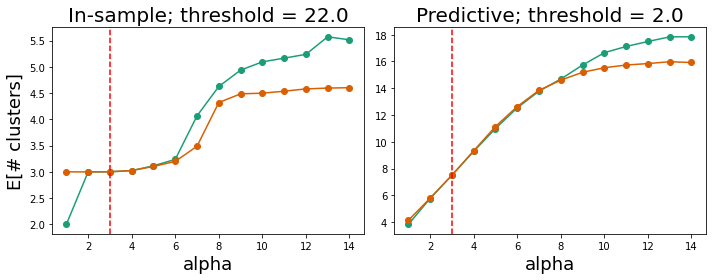

In [32]:
fig, axarr = plt.subplots(1, 2, figsize = (10, 4))

# in sample number of clusters
result_loading_utils.plot_post_stat_per_epsilon(get_n_clusters_insample_thresh, 
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               axarr[0])
# axarr[0].legend()
axarr[0].set_title('In-sample; threshold = {}'.format(threshold1), fontsize = title_fontsize)
axarr[0].set_ylabel('E[# clusters]')

# predictive number of clusters
result_loading_utils.plot_post_stat_per_epsilon(get_n_clusters_pred_thresh,
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               axarr[1])
axarr[1].set_title('Predictive; threshold = {}'.format(threshold2), fontsize = title_fontsize)

for i in range(2):
    axarr[i].axvline(alpha0, 
                     color = 'red', 
                     linestyle = '--')
    axarr[i].set_xlabel('alpha')
    # axarr[i].set_ylabel('E[# clusters]')

fig.tight_layout()

# fig.savefig('../../writing/notes_for_tamara/figures/structure_alpha_e_num_clusters_thresh.png')

# Cluster weights

In [33]:
def get_cluster_weights(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.get_e_num_loci_per_cluster(g_obs, vb_params_dict, gh_loc, gh_weights)
#     return posterior_quantities_lib.get_e_num_ind_per_cluster(vb_params_dict, gh_loc, gh_weights)

In [34]:
def plot_e_num_obs_trace(): 
    
    # get arrays of mixture weights
    refit_array = result_loading_utils.get_post_stat_vec(get_cluster_weights, refit_list)
    lr_array = result_loading_utils.get_post_stat_vec(get_cluster_weights, lr_list)
    
        
    fig, ax = plt.subplots(2, 4, figsize = (16, 6), sharex = True) 
    
    for k in range(8): 
        x0 = k // 4
        x1 = k % 4
        ax[x0, x1].plot(alpha_list, 
                       refit_array[:, k], 
                       '-o',
                       color = result_loading_utils.refit_color, 
                       label = 'refit')
        
        ax[x0, x1].plot(alpha_list, 
                       lr_array[:, k], 
                       '-o',
                       color = result_loading_utils.lr_color, 
                       label = 'lr')
        
        ax[x0, x1].set_title('k = {}'.format(k), fontsize = title_fontsize)
        ax[x0, x1].axvline(alpha0, 
                           color = 'red', 
                           linestyle = '--')
        
        
        if k == 0: 
            ax[x0, x1].legend()
            
    for k in range(4): 
        ax[-1, k].set_xlabel('alpha')
        
    for k in range(2): 
        ax[k, 0].set_ylabel('E(# loci)')
    
    fig.tight_layout()


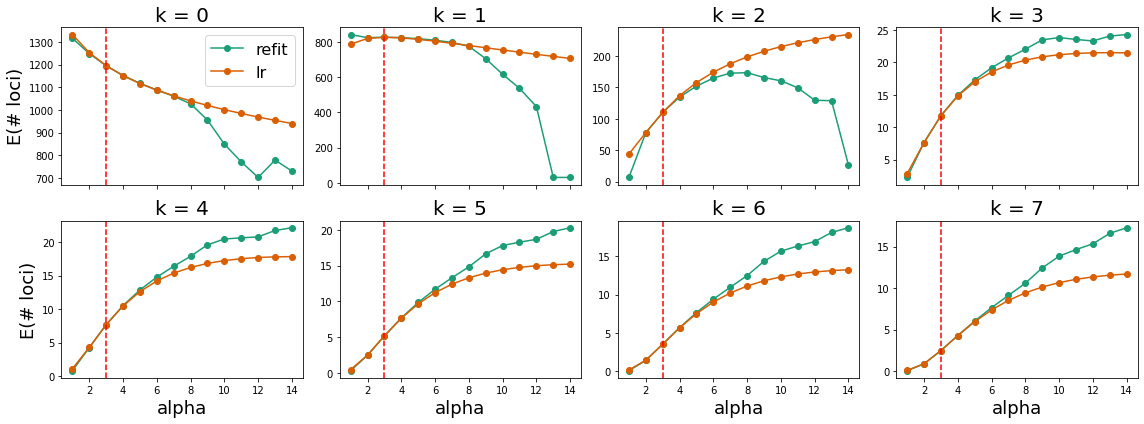

In [35]:
plot_e_num_obs_trace()

# Coclustering

In [36]:
@jax.jit
def get_coclustering(vb_params_free): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, 
                                             free = True)
    
    e_ind_admix = posterior_quantities_lib.get_vb_expectations(vb_params_dict, gh_loc, gh_weights)[0][perm_obs]
    
    return np.dot(e_ind_admix, e_ind_admix.transpose())

In [37]:
def get_coclust_mean_abs_diff(vb_params_free): 
    init_coclust = get_coclustering(vb_opt)
    pert_coclust = get_coclustering(vb_params_free) 
    
    return np.abs(pert_coclust - init_coclust).mean()

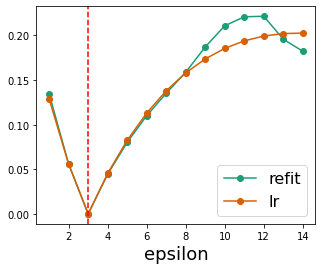

In [38]:
fig, ax = plt.subplots(1, 1, figsize = (5, 4))

result_loading_utils.plot_post_stat_per_epsilon(get_coclust_mean_abs_diff, 
                                               refit_list,
                                               lr_list,
                                               alpha_list, 
                                               ax)
ax.axvline(alpha0, 
           color = 'red', 
           linestyle = '--')

ax.legend()

In [39]:
def plot_coclustering_at_alpha(alpha_pert, fig, axarr): 
    
    alpha_indx = np.argwhere(alpha_list == alpha_pert).squeeze()
    
    coclust_init = get_coclustering(vb_opt)
    coclust_lr = get_coclustering(lr_list[alpha_indx])
    coclust_refit = get_coclustering(refit_list[alpha_indx])
    
    result_loading_utils.plot_colormaps(coclust_refit,
                                   coclust_lr,
                                   coclust_init,
                                   fig,
                                   axarr, 
                                   plot_initial = False)
    
    return coclust_init, coclust_lr, coclust_refit

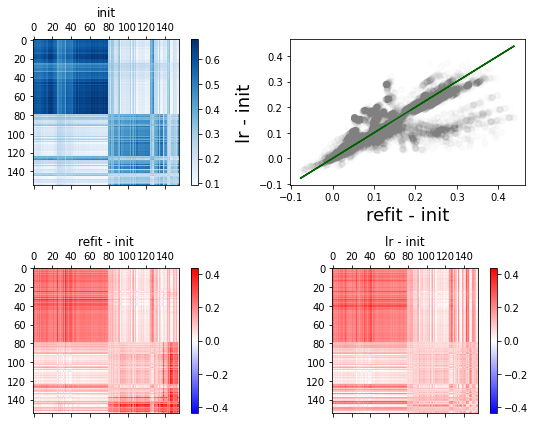

In [40]:
alpha_pert = 1

fig, axarr = plt.subplots(2, 2, figsize = (8, 6))

###############
# Get and plot co-clustering matrices
###############
coclust_init, coclust_lr, coclust_refit = plot_coclustering_at_alpha(alpha_pert, fig, axarr[1])

################
# initial co-clustering matrix
################
im0 = axarr[0, 0].matshow(coclust_init, 
                 cmap = plt.get_cmap('Blues'))
axarr[0, 0].set_title('init')
fig.colorbar(im0, ax = axarr[0, 0])

################
# differences
################
result_loading_utils.print_diff_plot(coclust_refit.flatten(),
                                     coclust_lr.flatten(), 
                                    coclust_init.flatten(), 
                                    axarr[0, 1], 
                                    alpha = 0.01)

fig.tight_layout()

# figures for meeting w tamara

In [41]:
def plot_e_num_obs_trace2(): 
    
    # get arrays of mixture weights
    refit_array = result_loading_utils.get_post_stat_vec(get_cluster_weights, refit_list)
    lr_array = result_loading_utils.get_post_stat_vec(get_cluster_weights, lr_list)
    
        
    fig, ax = plt.subplots(1, 4, figsize = (16, 4), sharex = True) 
    
    for k in range(4): 
        ax[k].plot(alpha_list, 
                       refit_array[:, k], 
                       '-o',
                       color = result_loading_utils.refit_color, 
                       label = 'refit')
        
        ax[k].plot(alpha_list, 
                       lr_array[:, k], 
                       '-o',
                       color = result_loading_utils.lr_color, 
                       label = 'lr')
        
        ax[k].set_title('k = {}'.format(k), fontsize = title_fontsize)
        ax[k].axvline(alpha0, 
                           color = 'red', 
                           linestyle = '--')
        
    ax[0].legend()
    ax[0].set_ylabel('E(# loci)')
    
            
    for k in range(4): 
        ax[k].set_xlabel('alpha')
        
    fig.tight_layout()
    
    # fig.savefig('../../writing/notes_for_tamara/figures/structure_alpha_mixture_weights.png')

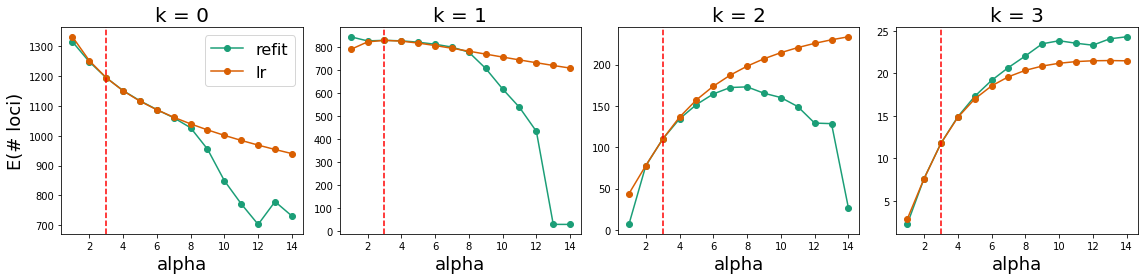

In [42]:
plot_e_num_obs_trace2()

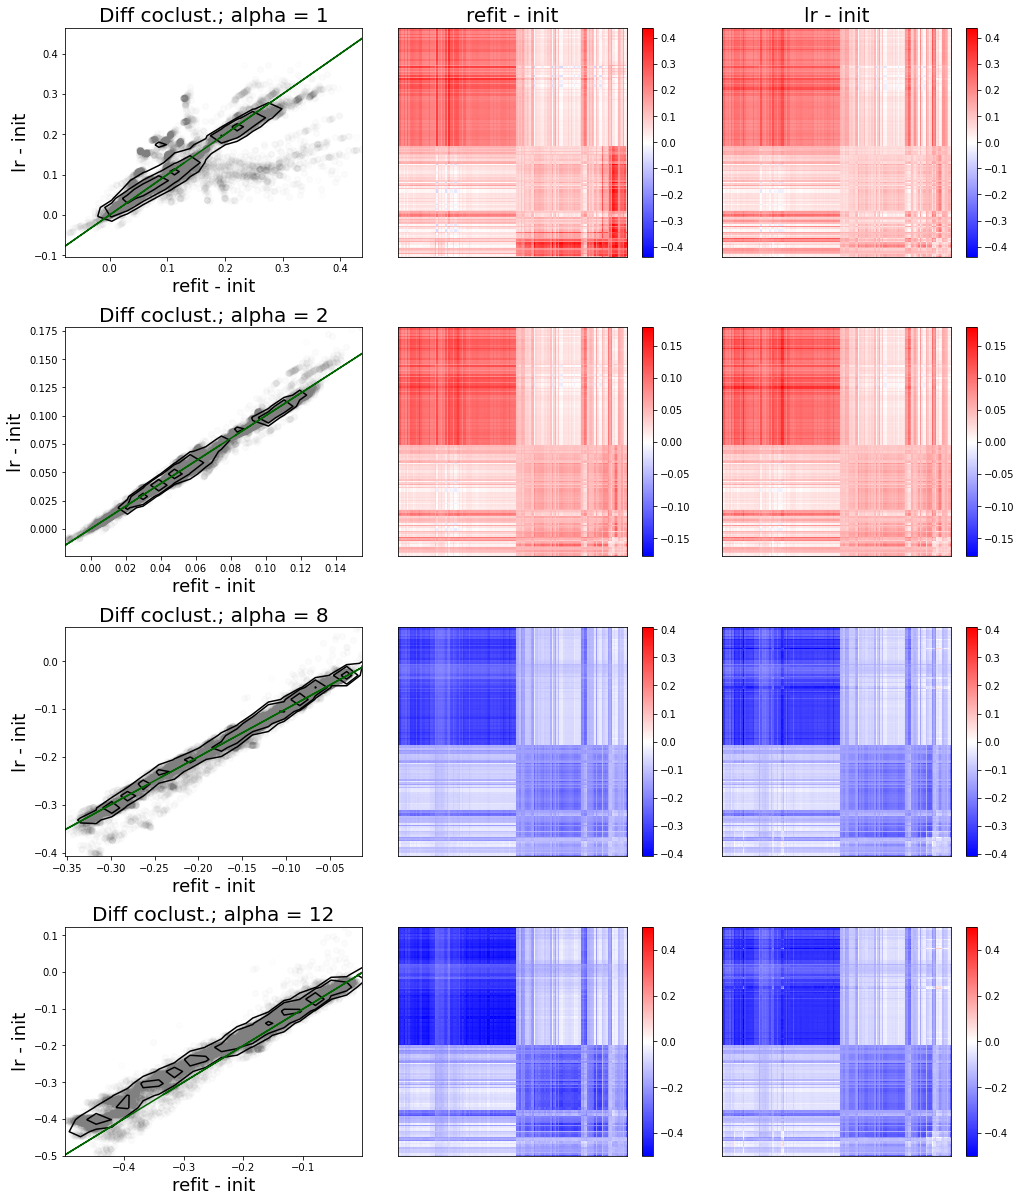

In [45]:
fig, axarr = plt.subplots(4, 3, figsize = (12 * 1.2, 14 * 1.2)) 

alpha_pert_vec = [1, 2, 8, 12]

for k in range(len(alpha_pert_vec)):
    
    # plot diff co-clustering matricies
    coclust_init, coclust_lr, coclust_refit = \
        plot_coclustering_at_alpha(alpha_pert_vec[k],
                                   fig,
                                   axarr[k, 1:3]);
    
    
    # print diff plot
    result_loading_utils.print_diff_plot(coclust_refit.flatten(),
                                     coclust_lr.flatten(), 
                                    coclust_init.flatten(), 
                                    axarr[k, 0], 
                                    alpha = 0.01, 
                                    plot_contours = True)
    
axarr[0, 1].set_title('refit - init', fontsize = title_fontsize)
axarr[0, 2].set_title('lr - init', fontsize = title_fontsize)
    
for k in range(4): 
    
    axarr[k, 1].set_title('', fontsize = title_fontsize)
    axarr[k, 2].set_title('', fontsize = title_fontsize)
    
    axarr[k, 1].set_xticks([])
    axarr[k, 1].set_yticks([])
    
    axarr[k, 2].set_xticks([])
    axarr[k, 2].set_yticks([])
    
    axarr[k, 0].set_title('Diff coclust.; alpha = {}'.format(alpha_pert_vec[k]), 
                          fontsize = title_fontsize)

axarr[0, 1].set_title('refit - init', fontsize = title_fontsize)
axarr[0, 2].set_title('lr - init', fontsize = title_fontsize)

fig.tight_layout();

# fig.savefig('../../writing/notes_for_tamara/figures/structure_alpha_coclust.png')